In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from itertools import combinations
from collections import Counter
import re

In [ ]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [ ]:
# Load the Datasets

order_df = pd.read_csv('order_data.csv')
customer_df = pd.read_csv('customer_data.csv')
store_df = pd.read_csv('store_data.csv')
test_df = pd.read_csv('test_data_question.csv')

In [ ]:
order_df.head()

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME
0,362204699,2156,2024-07-24,7247194287,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo
1,269612955,1419,2025-02-15,791214421,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo
2,585330633,2249,2025-02-15,7575285208,"{""orders"": [{""item_details"": [{""item_name"": ""2...",Digital,WWT,ToGo
3,950661333,2513,2024-03-29,4253875716,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo
4,434985772,1754,2024-04-08,7150407872,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo


In [ ]:
customer_df.head()

,CUSTOMER_ID,CUSTOMER_TYPE
0,362204699,Registered
1,269612955,Registered
2,585330633,Guest
3,950661333,Registered
4,434985772,Guest


In [ ]:
store_df.head()

,STORE_NUMBER,CITY,STATE,POSTAL_CODE
0,2156,GRAPEVINE,TX,76051
1,1419,HUNTERSVILLE,NC,28078
2,2249,NaN,NaN,32792
3,2513,LAS VEGAS,NV,89129
4,1754,ARDMORE,OK,73401


In [ ]:
# Merge the datsets

merged_df = pd.merge(order_df, customer_df, on='CUSTOMER_ID', how='left')
full_df = pd.merge(merged_df, store_df, on='STORE_NUMBER', how='left')


In [ ]:
full_df.head()

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE
0,362204699,2156,2024-07-24,7247194287,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051
1,269612955,1419,2025-02-15,791214421,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo,Registered,HUNTERSVILLE,NC,28078
2,585330633,2249,2025-02-15,7575285208,"{""orders"": [{""item_details"": [{""item_name"": ""2...",Digital,WWT,ToGo,Guest,NaN,NaN,32792
3,950661333,2513,2024-03-29,4253875716,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Registered,LAS VEGAS,NV,89129
4,434985772,1754,2024-04-08,7150407872,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo,Guest,ARDMORE,OK,73401


In [ ]:
full_df.isnull().sum()

,0
CUSTOMER_ID,0
STORE_NUMBER,0
ORDER_CREATED_DATE,0
ORDER_ID,0
ORDERS,0
ORDER_CHANNEL_NAME,0
ORDER_SUBCHANNEL_NAME,0
ORDER_OCCASION_NAME,0
CUSTOMER_TYPE,59
CITY,512196


In [ ]:
full_df['CUSTOMER_TYPE'].fillna('guest', inplace=True)

/tmp/ipython-input-3348888329.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['CUSTOMER_TYPE'].fillna('guest', inplace=True)


In [ ]:
full_df.isnull().sum()

,0
CUSTOMER_ID,0
STORE_NUMBER,0
ORDER_CREATED_DATE,0
ORDER_ID,0
ORDERS,0
ORDER_CHANNEL_NAME,0
ORDER_SUBCHANNEL_NAME,0
ORDER_OCCASION_NAME,0
CUSTOMER_TYPE,0
CITY,512196


In [ ]:
full_df['ORDER_CREATED_DATE'] = pd.to_datetime(full_df['ORDER_CREATED_DATE'])


In [ ]:
# Extracts item details from the first order in a JSON string, handling errors safely.

def parse_orders(orders_json_str):
    try:
        data = json.loads(orders_json_str)
        if 'orders' in data and isinstance(data['orders'], list) and len(data['orders']) > 0:
            if 'item_details' in data['orders'][0]:
                return data['orders'][0]['item_details']
        return []
    except (json.JSONDecodeError, TypeError, AttributeError, IndexError):
        return []

In [ ]:
# Copies dataset, extracts and explodes order items into separate rows, removing any missing values.

items_df = full_df.copy()
items_df['ORDER_ITEMS'] = items_df['ORDERS'].apply(parse_orders)
items_df = items_df.explode('ORDER_ITEMS').dropna(subset=['ORDER_ITEMS'])

In [ ]:
# Extracts 'item_name' and 'quantity' fields from each order item dictionary into separate columns.

items_df['item_name'] = items_df['ORDER_ITEMS'].apply(lambda x: x.get('item_name'))
items_df['quantity'] = items_df['ORDER_ITEMS'].apply(lambda x: x.get('quantity'))


In [ ]:
items_df = items_df.drop(columns=['ORDERS', 'ORDER_ITEMS'])

In [ ]:
items_df.reset_index(drop=True, inplace=True)

In [ ]:
items_df.head()

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE,item_name,quantity
0,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,Order Memo Not Paid,None
1,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,10 pc Grilled Wings Combo,None
2,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,8 pc Grilled Wings Combo,None
3,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,8 pc Spicy Wings Combo,None
4,269612955,1419,2025-02-15,791214421,Digital,WWT,ToGo,Registered,HUNTERSVILLE,NC,28078,Ranch Dip - Regular,None


/tmp/ipython-input-1503861440.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=full_df, x='CUSTOMER_TYPE', palette='viridis', order=full_df['CUSTOMER_TYPE'].value_counts().index)


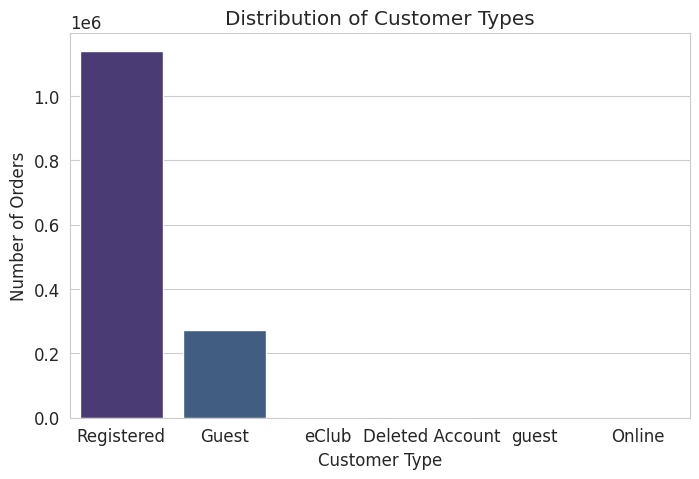

In [ ]:
# Plots the distribution of customer types using a count plot.

plt.figure(figsize=(8, 5))
sns.countplot(data=full_df, x='CUSTOMER_TYPE', palette='viridis', order=full_df['CUSTOMER_TYPE'].value_counts().index)
plt.title('Distribution of Customer Types')
plt.xlabel('Customer Type')
plt.ylabel('Number of Orders')
plt.show()

/tmp/ipython-input-2576793143.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_counts.values, y=item_counts.index, palette='plasma', orient='h')


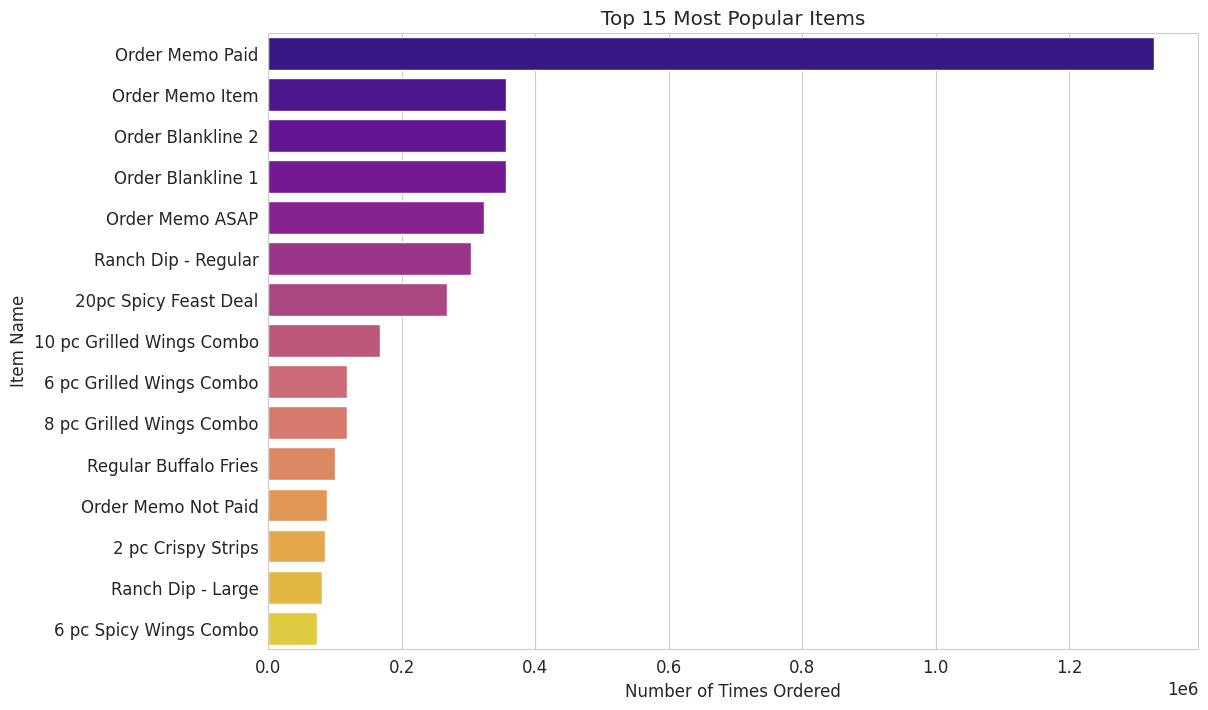

In [ ]:
# Displays a horizontal bar chart of the top 15 most frequently ordered items.

plt.figure(figsize=(12, 8))
item_counts = items_df['item_name'].value_counts().nlargest(15)
sns.barplot(x=item_counts.values, y=item_counts.index, palette='plasma', orient='h')
plt.title('Top 15 Most Popular Items')
plt.xlabel('Number of Times Ordered')
plt.ylabel('Item Name')
plt.show()

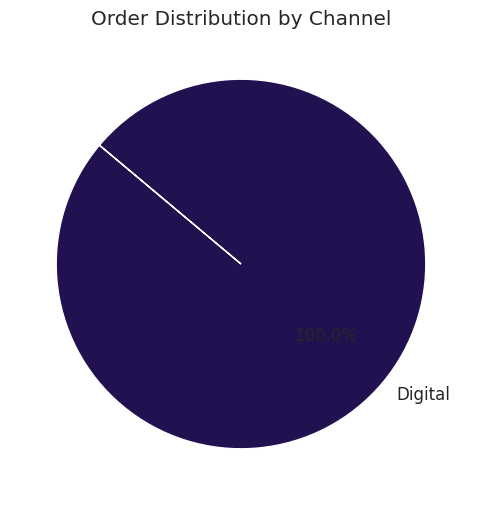

In [ ]:
# Plots a pie chart showing the percentage distribution of orders by sales channel.

plt.figure(figsize=(10, 6))
channel_counts = full_df['ORDER_CHANNEL_NAME'].value_counts()
plt.pie(channel_counts, labels=channel_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('magma'))
plt.title('Order Distribution by Channel')
plt.ylabel('')
plt.show()

/tmp/ipython-input-1726399643.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=full_df, x='ORDER_OCCASION_NAME', palette='cividis')


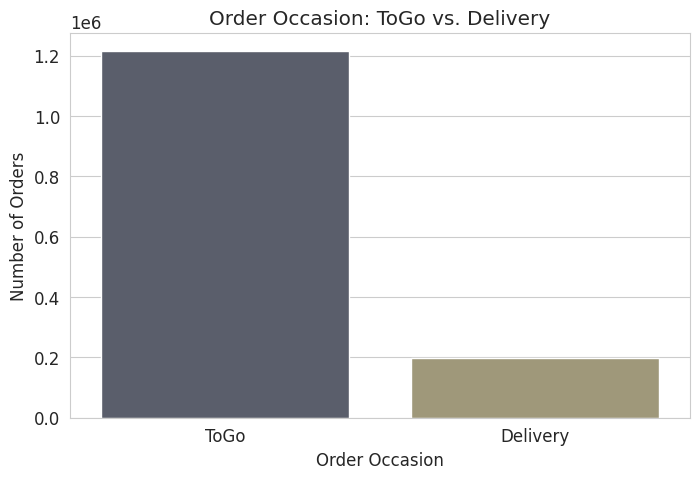

In [ ]:
# Creates a count plot comparing the number of orders for each order occasion (ToGo vs. Delivery).

plt.figure(figsize=(8, 5))
sns.countplot(data=full_df, x='ORDER_OCCASION_NAME', palette='cividis')
plt.title('Order Occasion: ToGo vs. Delivery')
plt.xlabel('Order Occasion')
plt.ylabel('Number of Orders')
plt.show()

/tmp/ipython-input-562954720.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette='crest')


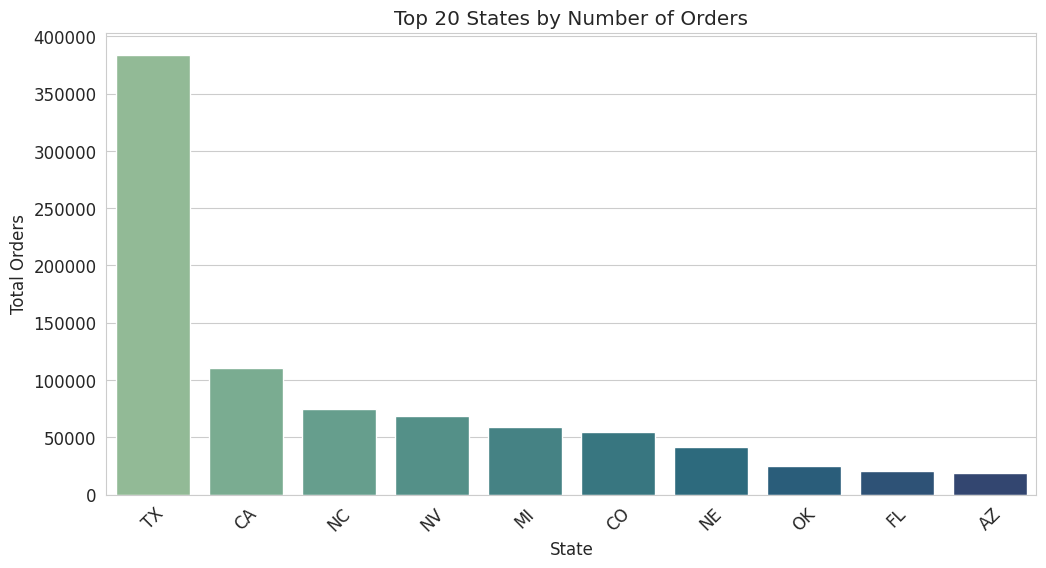

In [ ]:
# Displays a bar chart of the top 20 states with the highest number of orders.

plt.figure(figsize=(12, 6))
state_counts = full_df['STATE'].value_counts().nlargest(20)
sns.barplot(x=state_counts.index, y=state_counts.values, palette='crest')
plt.title('Top 20 States by Number of Orders')
plt.xlabel('State')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-4188150429.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=full_df, x='day_of_week', order=day_order, palette='rocket')


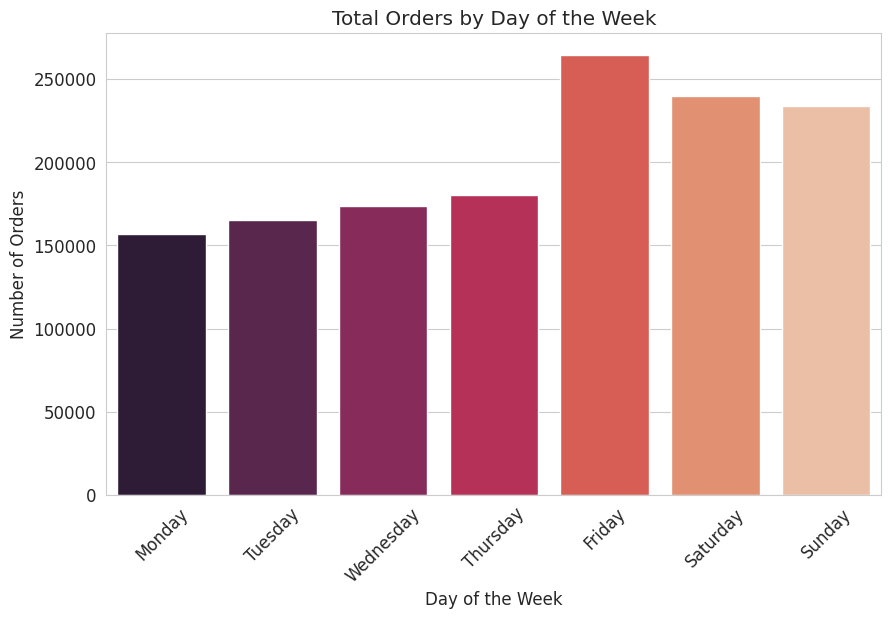

In [ ]:
# Adds day-of-week column and plots total orders for each day in chronological order.

full_df['day_of_week'] = full_df['ORDER_CREATED_DATE'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.countplot(data=full_df, x='day_of_week', order=day_order, palette='rocket')
plt.title('Total Orders by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# List of non-food placeholder items to be excluded from the dataset.

non_food_items = [
    'Order Memo Paid', 'Order Memo Item', 'Order Blankline 2',
    'Order Blankline 1', 'Order Memo ASAP', 'Order Memo Not Paid'
]

In [ ]:
cleaned_items_df = items_df[~items_df['item_name'].isin(non_food_items)]

/tmp/ipython-input-1675138716.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_counts.values, y=item_counts.index, palette='plasma', orient='h')


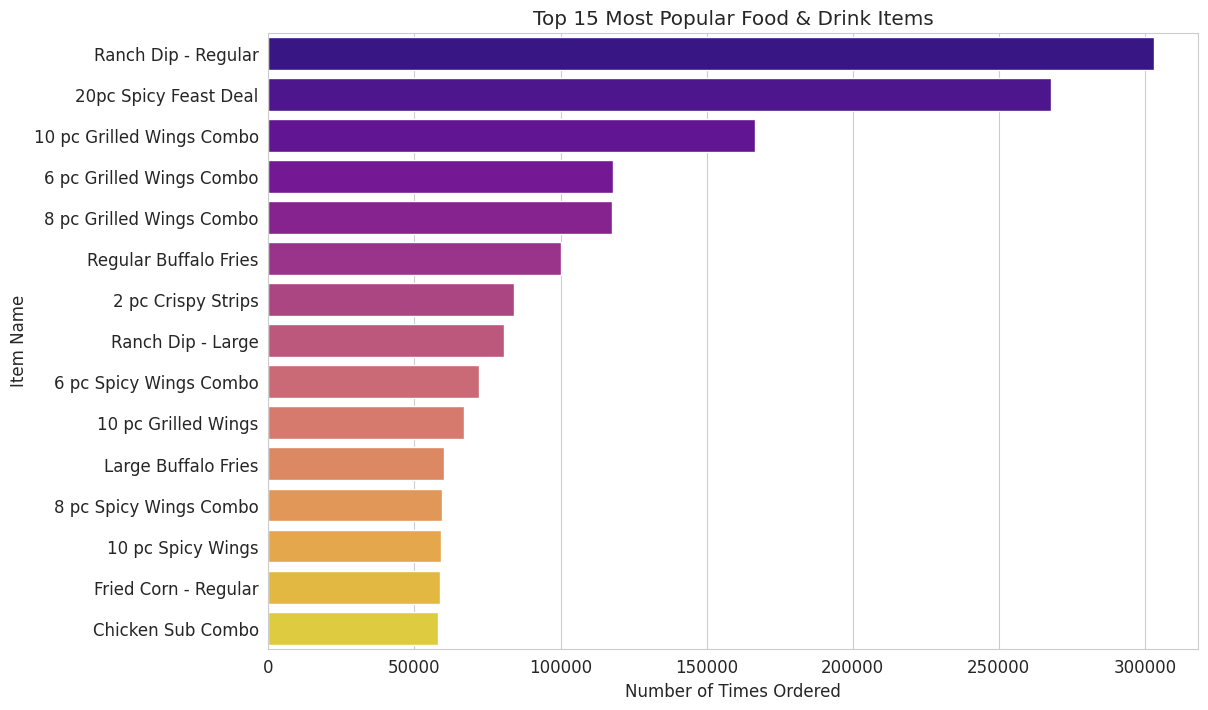

In [ ]:
# Plots a horizontal bar chart of the top 15 most frequently ordered food and drink items.

plt.figure(figsize=(12, 8))
item_counts = cleaned_items_df['item_name'].value_counts().nlargest(15)
sns.barplot(x=item_counts.values, y=item_counts.index, palette='plasma', orient='h')
plt.title('Top 15 Most Popular Food & Drink Items')
plt.xlabel('Number of Times Ordered')
plt.ylabel('Item Name')
plt.show()

In [ ]:
order_baskets = cleaned_items_df.groupby('ORDER_ID')['item_name'].apply(list)

In [ ]:
# Counts frequency of all unique item pairs across orders using combinations of size 2.

pair_counts = Counter()
for basket in order_baskets:
    pairs = combinations(sorted(set(basket)), 2)
    pair_counts.update(pairs)

In [1]:
# Top 10 most frequent item pairs:

for pair, count in pair_counts.most_common(10):
    print(f"- {pair}: {count} times")

NameError: name 'pair_counts' is not defined

In [ ]:
order_baskets = cleaned_items_df.groupby('ORDER_ID')['item_name'].apply(list)

In [ ]:
pair_counts = Counter()
for basket in order_baskets:
    pairs = combinations(sorted(set(basket)), 2)
    pair_counts.update(pairs)

In [ ]:
# Top 15 most frequent item pairs:

popular_pairs_df = pd.DataFrame(pair_counts.most_common(15), columns=['item_pair', 'frequency'])
print(popular_pairs_df)


Top 15 most frequent item pairs:
                                           item_pair  frequency
0   (10 pc Grilled Wings Combo, Ranch Dip - Regular)      46345
1       (Ranch Dip - Regular, Regular Buffalo Fries)      42146
2         (10 pc Grilled Wings, Ranch Dip - Regular)      38946
3           (10 pc Spicy Wings, Ranch Dip - Regular)      31620
4    (8 pc Grilled Wings Combo, Ranch Dip - Regular)      30316
5    (6 pc Grilled Wings Combo, Ranch Dip - Regular)      26554
6       (20pc Spicy Feast Deal, Ranch Dip - Regular)      26235
7          (2 pc Crispy Strips, Ranch Dip - Regular)      21994
8         (Large Buffalo Fries, Ranch Dip - Regular)      19255
9         (15 pc Grilled Wings, Ranch Dip - Regular)      19148
10       (Fried Corn - Regular, Ranch Dip - Regular)      19044
11        (20 pc Grilled Wings, Ranch Dip - Regular)      16520
12     (6 pc Spicy Wings Combo, Ranch Dip - Regular)      16298
13    (10 pc Spicy Wings Combo, Ranch Dip - Regular)      16014
14    

In [ ]:
top_items = cleaned_items_df['item_name'].value_counts().nlargest(5).index

In [ ]:
top_items_df = cleaned_items_df[cleaned_items_df['item_name'].isin(top_items)]

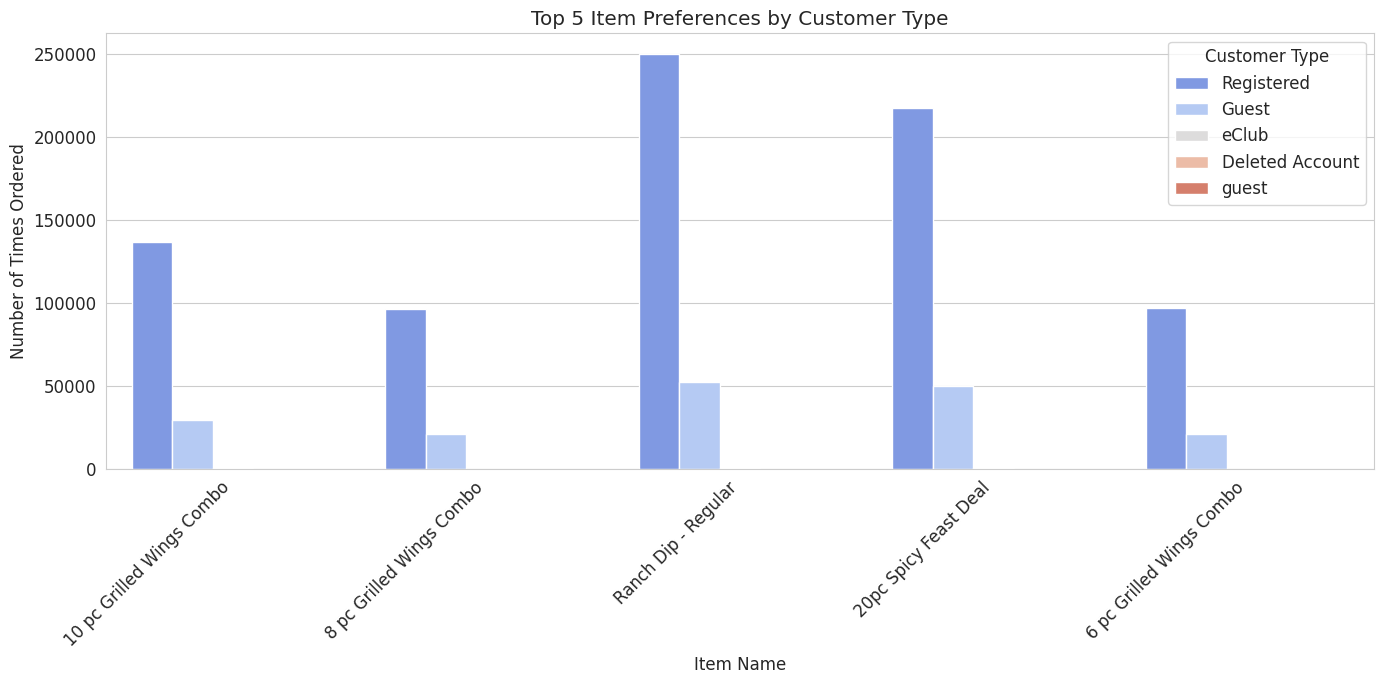

In [ ]:
# Plots top 5 items ordered, grouped by customer type, using a count plot with color-coded categories.

plt.figure(figsize=(14, 7))
sns.countplot(data=top_items_df, x='item_name', hue='CUSTOMER_TYPE', palette='coolwarm')
plt.title('Top 5 Item Preferences by Customer Type')
plt.xlabel('Item Name')
plt.ylabel('Number of Times Ordered')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Customer Type')
plt.tight_layout()
plt.show()

In [ ]:
snapshot_date = full_df['ORDER_CREATED_DATE'].max() + pd.Timedelta(days=1)


Snapshot date for Recency calculation: 2025-04-30 00:00:00


In [ ]:
# Creates an RFM table with Recency (days since last order) and Frequency (unique orders) per customer.

rfm_df = full_df.groupby('CUSTOMER_ID').agg({
    'ORDER_CREATED_DATE': lambda date: (snapshot_date - date.max()).days, # Recency
    'ORDER_ID': 'nunique', # Frequency
}).reset_index()

In [ ]:
# Adds a monetary value proxy (total items ordered) to the RFM table and fills missing values with 0.

monetary_proxy = cleaned_items_df.groupby('CUSTOMER_ID').size().reset_index(name='MonetaryProxy')
rfm_df = pd.merge(rfm_df, monetary_proxy, on='CUSTOMER_ID', how='left')
rfm_df['MonetaryProxy'].fillna(0, inplace=True)

/tmp/ipython-input-2111009315.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_df['MonetaryProxy'].fillna(0, inplace=True)


In [ ]:
rfm_df.rename(columns={'ORDER_CREATED_DATE': 'Recency',
                       'ORDER_ID': 'Frequency'}, inplace=True)


In [ ]:
rfm_df.head()

,CUSTOMER_ID,Recency,Frequency,MonetaryProxy
0,1588,369,4,6
1,2475,47,2,6
2,4769,319,1,2
3,5791,266,1,1
4,6524,63,3,6


In [ ]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

In [ ]:
# Assigns R, F, and M scores (1–4) to each customer based on quartile rankings for Recency, Frequency, and MonetaryProxy.

rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=4, labels=r_labels, duplicates='drop').astype(int)
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), q=4, labels=f_labels).astype(int)
rfm_df['M_Score'] = pd.qcut(rfm_df['MonetaryProxy'].rank(method='first'), q=4, labels=m_labels).astype(int)

In [ ]:
# Creates RFM segment codes and overall RFM score by summing individual R, F, and M scores.

rfm_df['RFM_Segment'] = rfm_df.apply(lambda x: str(x['R_Score']) + str(x['F_Score']) + str(x['M_Score']), axis=1)
rfm_df['RFM_Score'] = rfm_df[['R_Score','F_Score','M_Score']].sum(axis=1)

In [ ]:
rfm_df.head()

,CUSTOMER_ID,Recency,Frequency,MonetaryProxy,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,1588,369,4,6,1,4,4,144,9
1,2475,47,2,6,4,3,4,434,11
2,4769,319,1,2,1,1,2,112,4
3,5791,266,1,1,2,1,1,211,4
4,6524,63,3,6,4,4,4,444,12


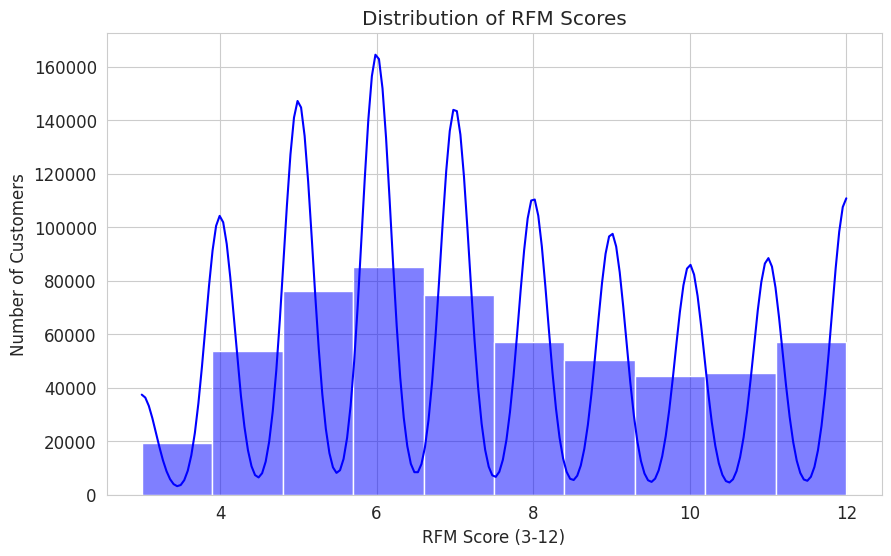

In [ ]:
# Plots the distribution of overall RFM scores with a histogram and KDE curve.

plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['RFM_Score'], bins=10, kde=True, color='blue')
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score (3-12)')
plt.ylabel('Number of Customers')
plt.show()

In [ ]:
# Categorizes customers into segments (e.g., Champions, Loyal, At-Risk) based on their RFM score.

def assign_customer_segment(score):
    if score >= 11:
        return 'Champions'
    elif score >= 9:
        return 'Loyal Customers'
    elif score >= 6:
        return 'Potential Loyalists'
    elif score >= 4:
        return 'At-Risk Customers'
    else:
        return 'Hibernating'

In [ ]:
# Assigns each customer to a segment based on their RFM score using the assign_customer_segment function.

rfm_df['Segment'] = rfm_df['RFM_Score'].apply(assign_customer_segment)

/tmp/ipython-input-157113098.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis', order=segment_counts.index)


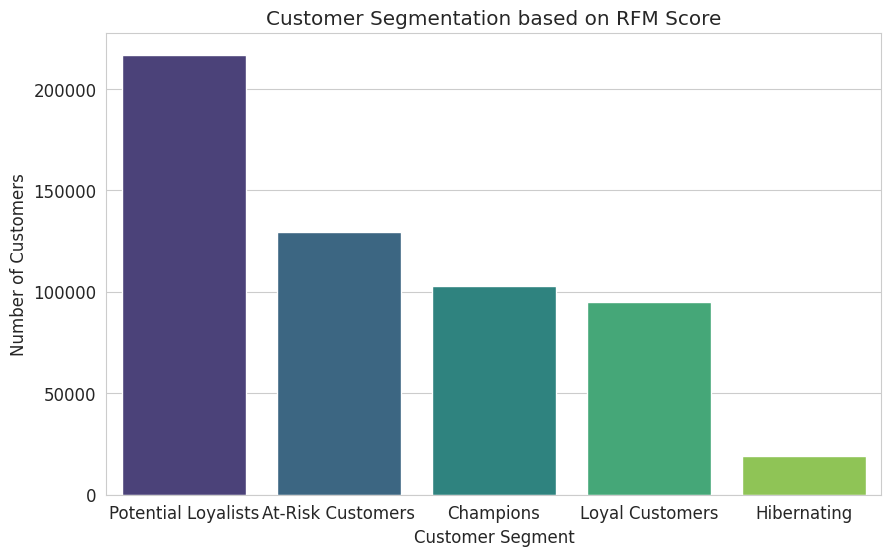

In [ ]:
# Plots the number of customers in each RFM-based segment as a bar chart.

plt.figure(figsize=(10, 6))
segment_counts = rfm_df['Segment'].value_counts()
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis', order=segment_counts.index)
plt.title('Customer Segmentation based on RFM Score')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.show()

In [ ]:
# Merge item data with customer RFM segments to associate each item with its customer's segment.

segmented_items_df = pd.merge(cleaned_items_df, rfm_df[['CUSTOMER_ID', 'Segment']], on='CUSTOMER_ID', how='left')
print("Merged RFM segments with item data.")

Merged RFM segments with item data.


In [ ]:
# Identify the top 10 overall items by sales, filter segmented data for these items,  

top_10_overall_items = cleaned_items_df['item_name'].value_counts().nlargest(10).index.tolist()
segment_plot_df = segmented_items_df[segmented_items_df['item_name'].isin(top_10_overall_items)]

# create a pivot table counting orders per segment and item,  
segment_pivot = segment_plot_df.pivot_table(index='Segment', columns='item_name', values='ORDER_ID', aggfunc='count').fillna(0)

# and normalize counts to get relative proportions within each segment.
segment_pivot_normalized = segment_pivot.div(segment_pivot.sum(axis=1), axis=0)

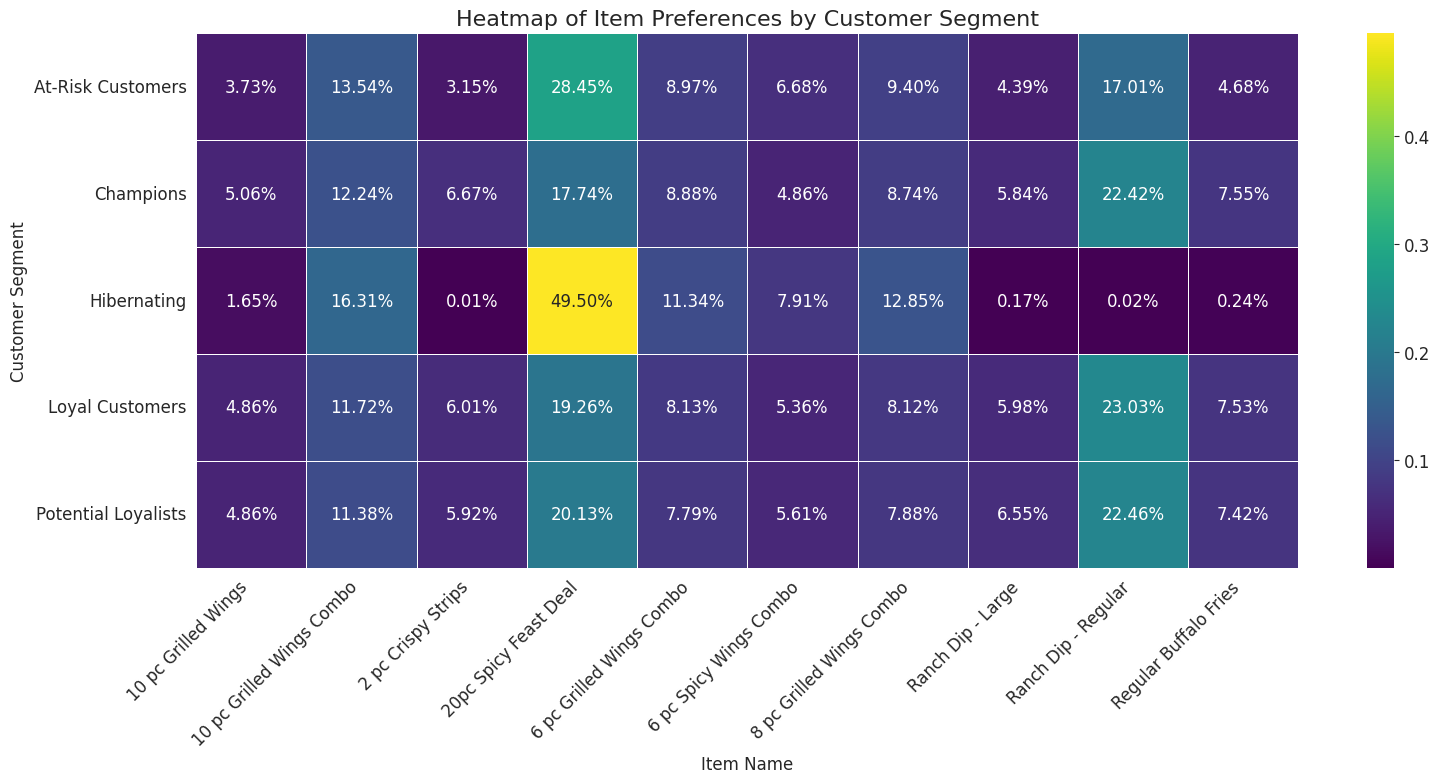

In [ ]:
# Visualize normalized item preferences across customer segments using a heatmap with percentage annotations and customized styling.

plt.figure(figsize=(16, 8))
sns.heatmap(
    segment_pivot_normalized,
    annot=True,
    fmt=".2%", # Format as percentage
    cmap='viridis',
    linewidths=.5
)
plt.title('Heatmap of Item Preferences by Customer Segment', fontsize=16)
plt.xlabel('Item Name', fontsize=12)
plt.ylabel('Customer Segment', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Print top 5 purchased items per customer segment along with segment size,  
# and provide tailored marketing strategies for each segment to boost engagement and loyalty.


for segment in segment_pivot.index:
    top_items_for_segment = segment_pivot.loc[segment].nlargest(5)
    print(f"--- {segment} ---")
    print(f"This group makes up {len(rfm_df[rfm_df['Segment'] == segment]) / len(rfm_df):.1%} of all customers.")
    print("Top 5 Purchased Items:")
    for item, count in top_items_for_segment.items():
        if count > 0:
            print(f"  - {item}")

    # Suggest a recommendation strategy
    if segment == 'Champions':
        print("\n\t>> STRATEGY: These are your best customers. Recommend new menu items, premium combos, and exclusive offers to maintain loyalty. They are most likely to try new things.")
    elif segment == 'Loyal Customers':
        print("\n\t>> STRATEGY: They order frequently but might not spend as much. Encourage them to increase their cart size by recommending popular sides and drinks that pair well with their frequent purchases.")
    elif segment == 'Potential Loyalists':
        print("\n\t>> STRATEGY: This group has potential. Nudge them towards becoming loyal customers by offering loyalty points or small discounts on their next order. Recommend popular items to ensure a positive experience.")
    elif segment == 'At-Risk Customers':
        print("\n\t>> STRATEGY: This group hasn't ordered in a while. Send re-engagement campaigns (e.g., 'We miss you!') with a special offer on their past favorite items to win them back.")
    elif segment == 'Hibernating':
        print("\n\t>> STRATEGY: These are lapsed customers. A significant, one-time discount on a highly popular item (like a free drink or fries) might be needed to reactivate them.")
    print("-" * (len(segment) + 8) + "\n")


--- At-Risk Customers ---
This group makes up 23.0% of all customers.
Top 5 Purchased Items:
  - 20pc Spicy Feast Deal
  - Ranch Dip - Regular
  - 10 pc Grilled Wings Combo
  - 8 pc Grilled Wings Combo
  - 6 pc Grilled Wings Combo

	>> STRATEGY: This group hasn't ordered in a while. Send re-engagement campaigns (e.g., 'We miss you!') with a special offer on their past favorite items to win them back.
-------------------------

--- Champions ---
This group makes up 18.2% of all customers.
Top 5 Purchased Items:
  - Ranch Dip - Regular
  - 20pc Spicy Feast Deal
  - 10 pc Grilled Wings Combo
  - 6 pc Grilled Wings Combo
  - 8 pc Grilled Wings Combo

	>> STRATEGY: These are your best customers. Recommend new menu items, premium combos, and exclusive offers to maintain loyalty. They are most likely to try new things.
-----------------

--- Hibernating ---
This group makes up 3.4% of all customers.
Top 5 Purchased Items:
  - 20pc Spicy Feast Deal
  - 10 pc Grilled Wings Combo
  - 8 pc Grille

In [ ]:
cleaned_items_df

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE,item_name,quantity
1,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,10 pc Grilled Wings Combo,None
2,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,8 pc Grilled Wings Combo,None
3,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,8 pc Spicy Wings Combo,None
4,269612955,1419,2025-02-15,791214421,Digital,WWT,ToGo,Registered,HUNTERSVILLE,NC,28078,Ranch Dip - Regular,None
5,269612955,1419,2025-02-15,791214421,Digital,WWT,ToGo,Registered,HUNTERSVILLE,NC,28078,50 pc Grilled Wings,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5657818,125634365,1419,2025-01-22,9371418183,Digital,WWT,ToGo,Guest,HUNTERSVILLE,NC,28078,Ranch Dip - Regular,None
5657821,125634365,4595,2025-02-13,8082200700,Digital,WWT,ToGo,Guest,CHARLOTTE,NC,28208,4 pc Crispy Strips,None
5657823,125634365,1419,2024-11-30,8865782702,Digital,WWT,ToGo,Guest,HUNTERSVILLE,NC,28078,Chicken Sub Combo,None
5657824,125634365,4595,2024-12-16,8030111101,Digital,WWT,ToGo,Guest,CHARLOTTE,NC,28208,Ranch Dip - Regular,None


In [ ]:
temp_items_df = cleaned_items_df.copy()
temp_items_df.head()

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE,item_name,quantity
1,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,10 pc Grilled Wings Combo,None
2,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,8 pc Grilled Wings Combo,None
3,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,8 pc Spicy Wings Combo,None
4,269612955,1419,2025-02-15,791214421,Digital,WWT,ToGo,Registered,HUNTERSVILLE,NC,28078,Ranch Dip - Regular,None
5,269612955,1419,2025-02-15,791214421,Digital,WWT,ToGo,Registered,HUNTERSVILLE,NC,28078,50 pc Grilled Wings,None


In [ ]:
# Define a function to extract piece counts (e.g., "6 pc") from item names,  
# clean the item name by removing piece count text,  
# and update the quantity accordingly, handling missing or non-numeric quantities.

import re

def extract_piece_count_and_clean_name(row):
    item_name = row['item_name']
    quantity = row['quantity']

    # Regex to find piece counts like "N pc", "Npc", or "N pc Family"
    # Captures the number N
    match = re.search(r'(\d+)\s*pc(?:\s+Family)?', item_name, re.IGNORECASE)

    if match:
        piece_count = int(match.group(1))
        cleaned_item_name = re.sub(r'\s*\d+\s*pc(?:\s+Family)?', '', item_name, flags=re.IGNORECASE).strip()
        cleaned_item_name = re.sub(r'^\s*[-–]\s*', '', cleaned_item_name).strip()
        cleaned_item_name = re.sub(r'\s*[-–]\s*$', '', cleaned_item_name).strip()

        if pd.isna(quantity) or quantity is None:
            updated_quantity = piece_count
        else:
            try:
                updated_quantity = float(quantity) * piece_count
            except (ValueError, TypeError):
                updated_quantity = piece_count
    else:
        cleaned_item_name = item_name
        if pd.isna(quantity) or quantity is None:
            updated_quantity = 1
        else:
             try:
                updated_quantity = float(quantity)
             except (ValueError, TypeError):
                 updated_quantity = 1

    return cleaned_item_name, updated_quantity

print("Function 'extract_piece_count_and_clean_name' defined.")

Function 'extract_piece_count_and_clean_name' defined.


In [ ]:
# Apply the piece count extraction function row-wise to create new columns for cleaned item names and updated quantities,  
# then display a preview of these new columns alongside original data.

temp_items_df[['cleaned_item_name', 'updated_quantity']] = temp_items_df.apply(
    extract_piece_count_and_clean_name, axis=1, result_type='expand'
)

# Display the head to show the new columns
display(temp_items_df[['item_name', 'quantity', 'cleaned_item_name', 'updated_quantity']].head())

,item_name,quantity,cleaned_item_name,updated_quantity
1,10 pc Grilled Wings Combo,None,Grilled Wings Combo,10
2,8 pc Grilled Wings Combo,None,Grilled Wings Combo,8
3,8 pc Spicy Wings Combo,None,Spicy Wings Combo,8
4,Ranch Dip - Regular,None,Ranch Dip - Regular,1
5,50 pc Grilled Wings,None,Grilled Wings,50


In [ ]:
display(temp_items_df[['item_name', 'quantity', 'cleaned_item_name', 'updated_quantity']].head())

,item_name,quantity,cleaned_item_name,updated_quantity
1,10 pc Grilled Wings Combo,None,Grilled Wings Combo,10
2,8 pc Grilled Wings Combo,None,Grilled Wings Combo,8
3,8 pc Spicy Wings Combo,None,Spicy Wings Combo,8
4,Ranch Dip - Regular,None,Ranch Dip - Regular,1
5,50 pc Grilled Wings,None,Grilled Wings,50


In [ ]:
# Reset indexes to align dataframes, then merge cleaned item names and updated quantities back into the original dataframe,  

cleaned_items_df_reset = cleaned_items_df.reset_index()
temp_items_df_reset = temp_items_df.reset_index()

# Merge the cleaned item name and updated quantity back into the original dataframe
cleaned_items_df = pd.merge(
    cleaned_items_df_reset,
    temp_items_df_reset[['index', 'cleaned_item_name', 'updated_quantity']],
    on='index', 
    how='left' 
).set_index('index') 

# Drop the old 'quantity' column as it's replaced by 'updated_quantity'
if 'quantity' in cleaned_items_df.columns:
    cleaned_items_df = cleaned_items_df.drop(columns=['quantity'])

print("Merged 'cleaned_item_name' and 'updated_quantity' into cleaned_items_df.")
print("\nUpdated cleaned_items_df Head:")
display(cleaned_items_df.head())

Merged 'cleaned_item_name' and 'updated_quantity' into cleaned_items_df.

Updated cleaned_items_df Head:


,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE,item_name,cleaned_item_name,updated_quantity
index,,,,,,,,,,,,,,
1,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,10 pc Grilled Wings Combo,Grilled Wings Combo,10
2,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,8 pc Grilled Wings Combo,Grilled Wings Combo,8
3,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,Registered,GRAPEVINE,TX,76051,8 pc Spicy Wings Combo,Spicy Wings Combo,8
4,269612955,1419,2025-02-15,791214421,Digital,WWT,ToGo,Registered,HUNTERSVILLE,NC,28078,Ranch Dip - Regular,Ranch Dip - Regular,1
5,269612955,1419,2025-02-15,791214421,Digital,WWT,ToGo,Registered,HUNTERSVILLE,NC,28078,50 pc Grilled Wings,Grilled Wings,50


In [ ]:
# Print the count of unique values for selected categorical columns in `cleaned_items_df` and `full_df`.  
# For columns with fewer than 50 unique values, display their top 10 most frequent entries,  
# handling any exceptions during value counting gracefully.

print("Unique values in cleaned_items_df:")
print("-" * 40)

categorical_cols_cleaned_items = [
    'cleaned_item_name',
    'ORDER_CHANNEL_NAME',
    'ORDER_SUBCHANNEL_NAME',
    'ORDER_OCCASION_NAME',
    'CUSTOMER_TYPE',
    'STATE',
    'CITY',
    'POSTAL_CODE'
]

for col in categorical_cols_cleaned_items:
    if col in cleaned_items_df.columns:
        unique_count = cleaned_items_df[col].nunique()
        print(f"{col}: {unique_count} unique values")
        if unique_count < 50: # Display top values for columns with fewer unique values
            print(f"Top 10 unique values for {col}:")
            try:
                # Handle potential missing values before value_counts
                print(cleaned_items_df[col].value_counts().nlargest(10).index.tolist())
            except Exception as e:
                print(f"Could not display top values for {col}: {e}")
        print("-" * 20)

print("\nUnique values in full_df:")
print("-" * 40)

categorical_cols_full = [
    'ORDER_CHANNEL_NAME',
    'ORDER_SUBCHANNEL_NAME',
    'ORDER_OCCASION_NAME',
    'CUSTOMER_TYPE',
    'STATE',
    'CITY',
    'POSTAL_CODE',
    'day_of_week'
]

for col in categorical_cols_full:
     if col in full_df.columns:
        unique_count = full_df[col].nunique()
        print(f"{col}: {unique_count} unique values")
        if unique_count < 50: # Display top values for columns with fewer unique values
            print(f"Top 10 unique values for {col}:")
            try:
                 # Handle potential missing values before value_counts
                print(full_df[col].value_counts().nlargest(10).index.tolist())
            except Exception as e:
                print(f"Could not display top values for {col}: {e}")
        print("-" * 20)

Unique values in cleaned_items_df:
----------------------------------------
cleaned_item_name: 82 unique values
--------------------
ORDER_CHANNEL_NAME: 1 unique values
Top 10 unique values for ORDER_CHANNEL_NAME:
['Digital']
--------------------
ORDER_SUBCHANNEL_NAME: 2 unique values
Top 10 unique values for ORDER_SUBCHANNEL_NAME:
['WWT', 'Grub Hub Marketplace']
--------------------
ORDER_OCCASION_NAME: 2 unique values
Top 10 unique values for ORDER_OCCASION_NAME:
['ToGo', 'Delivery']
--------------------
CUSTOMER_TYPE: 6 unique values
Top 10 unique values for CUSTOMER_TYPE:
['Registered', 'Guest', 'eClub', 'Deleted Account', 'guest', 'Online']
--------------------
STATE: 10 unique values
Top 10 unique values for STATE:
['TX', 'CA', 'NV', 'NC', 'MI', 'CO', 'NE', 'OK', 'FL', 'AZ']
--------------------
CITY: 21 unique values
Top 10 unique values for CITY:
['SAN ANTONIO', 'HOUSTON', 'LAS VEGAS', 'ATWATER', 'ARLINGTON', 'CHARLOTTE', 'LAVEEN', 'OMAHA', 'IRVING', 'EL PASO']
----------------

In [ ]:
print("Missing values in cleaned_items_df:")
print("-" * 40)
print(cleaned_items_df.isnull().sum())

Missing values in cleaned_items_df:
----------------------------------------
CUSTOMER_ID                    0
STORE_NUMBER                   0
ORDER_CREATED_DATE             0
ORDER_ID                       0
ORDER_CHANNEL_NAME             0
ORDER_SUBCHANNEL_NAME          0
ORDER_OCCASION_NAME            0
CUSTOMER_TYPE                  0
CITY                     1024523
STATE                    1116727
POSTAL_CODE               189239
item_name                      0
cleaned_item_name              0
updated_quantity               0
dtype: int64


In [ ]:
print("\nMissing values in full_df:")
print("-" * 40)
print(full_df.isnull().sum())


Missing values in full_df:
----------------------------------------
CUSTOMER_ID                   0
STORE_NUMBER                  0
ORDER_CREATED_DATE            0
ORDER_ID                      0
ORDERS                        0
ORDER_CHANNEL_NAME            0
ORDER_SUBCHANNEL_NAME         0
ORDER_OCCASION_NAME           0
CUSTOMER_TYPE                 0
CITY                     512196
STATE                    557621
POSTAL_CODE               93648
day_of_week                   0
dtype: int64


In [ ]:
print("\nMissing values in rfm_df:")
print("-" * 40)
print(rfm_df.isnull().sum())


Missing values in rfm_df:
----------------------------------------
CUSTOMER_ID      0
Recency          0
Frequency        0
MonetaryProxy    0
R_Score          0
F_Score          0
M_Score          0
RFM_Segment      0
RFM_Score        0
Segment          0
dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
cols_to_encode_cleaned_items = [
    'cleaned_item_name',
    'ORDER_CHANNEL_NAME',
    'ORDER_SUBCHANNEL_NAME',
    'ORDER_OCCASION_NAME',
    'CUSTOMER_TYPE',
    'STATE',
    'CITY',
    'POSTAL_CODE'
]

cols_to_encode_full = [
    'ORDER_CHANNEL_NAME',
    'ORDER_SUBCHANNEL_NAME',
    'ORDER_OCCASION_NAME',
    'CUSTOMER_TYPE',
    'STATE',
    'CITY',
    'POSTAL_CODE',
    'day_of_week'
]

In [ ]:
cleaned_items_df_encoded = cleaned_items_df.copy()

In [ ]:
# Encode categorical columns in `cleaned_items_df_encoded` using Label Encoding,  
# first filling missing values with 'Unknown' to avoid errors during encoding.

for col in cols_to_encode_cleaned_items:
    if col in cleaned_items_df_encoded.columns:
        # Fill missing values with 'Unknown' before encoding
        cleaned_items_df_encoded[col] = cleaned_items_df_encoded[col].fillna('Unknown')
        le = LabelEncoder()
        cleaned_items_df_encoded[col] = le.fit_transform(cleaned_items_df_encoded[col])

In [ ]:
display(cleaned_items_df_encoded.head())

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE,item_name,cleaned_item_name,updated_quantity
index,,,,,,,,,,,,,,
1,362204699,2156,2024-07-24,7247194287,0,1,1,3,7,9,18,10 pc Grilled Wings Combo,41,10
2,362204699,2156,2024-07-24,7247194287,0,1,1,3,7,9,18,8 pc Grilled Wings Combo,41,8
3,362204699,2156,2024-07-24,7247194287,0,1,1,3,7,9,18,8 pc Spicy Wings Combo,68,8
4,269612955,1419,2025-02-15,791214421,0,1,1,3,9,5,1,Ranch Dip - Regular,63,1
5,269612955,1419,2025-02-15,791214421,0,1,1,3,9,5,1,50 pc Grilled Wings,40,50


In [ ]:
full_df_encoded = full_df.copy()

In [ ]:
# Apply label encoding to specified categorical columns in `full_df_encoded`,  
# replacing missing values with 'Unknown' beforehand to ensure smooth encoding.

for col in cols_to_encode_full:
    if col in full_df_encoded.columns:
         # Fill missing values with 'Unknown' before encoding
        full_df_encoded[col] = full_df_encoded[col].fillna('Unknown')
        le = LabelEncoder()
        full_df_encoded[col] = le.fit_transform(full_df_encoded[col])

In [ ]:
display(full_df_encoded.head())

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE,day_of_week
0,362204699,2156,2024-07-24,7247194287,"{""orders"": [{""item_details"": [{""item_name"": ""O...",0,1,1,3,7,9,18,6
1,269612955,1419,2025-02-15,791214421,"{""orders"": [{""item_details"": [{""item_name"": ""R...",0,1,1,3,9,5,1,2
2,585330633,2249,2025-02-15,7575285208,"{""orders"": [{""item_details"": [{""item_name"": ""2...",0,1,1,1,20,10,4,2
3,950661333,2513,2024-03-29,4253875716,"{""orders"": [{""item_details"": [{""item_name"": ""O...",0,1,1,3,11,7,30,0
4,434985772,1754,2024-04-08,7150407872,"{""orders"": [{""item_details"": [{""item_name"": ""O...",0,1,1,1,1,8,12,1


In [ ]:
cleaned_items_df_encoded.head()

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE,item_name,cleaned_item_name,updated_quantity
index,,,,,,,,,,,,,,
1,362204699,2156,2024-07-24,7247194287,0,1,1,3,7,9,18,10 pc Grilled Wings Combo,41,10
2,362204699,2156,2024-07-24,7247194287,0,1,1,3,7,9,18,8 pc Grilled Wings Combo,41,8
3,362204699,2156,2024-07-24,7247194287,0,1,1,3,7,9,18,8 pc Spicy Wings Combo,68,8
4,269612955,1419,2025-02-15,791214421,0,1,1,3,9,5,1,Ranch Dip - Regular,63,1
5,269612955,1419,2025-02-15,791214421,0,1,1,3,9,5,1,50 pc Grilled Wings,40,50


In [ ]:
# Clean item names by converting to lowercase, removing quantity and unit patterns (e.g., "6 pc", "20 oz"),  

def clean_item_name(name):
    name = name.lower()
    name = re.sub(r'\b\d+\s?(pc|oz|liter|l|ml|ct|pack|inch|in|fl oz|combo|combo meal)\b', '', name)
    name = re.sub(r'\b\d+\b', '', name)
    name = re.sub(r'\s+', ' ', name).strip()

    return name

# Apply cleaning function
cleaned_items_df_encoded['item_name_no_qty'] = cleaned_items_df_encoded['item_name'].apply(clean_item_name)


In [ ]:
cleaned_items_df_encoded.head()

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE,item_name,cleaned_item_name,updated_quantity,item_name_no_qty
index,,,,,,,,,,,,,,,
1,362204699,2156,2024-07-24,7247194287,0,1,1,3,7,9,18,10 pc Grilled Wings Combo,41,10,grilled wings combo
2,362204699,2156,2024-07-24,7247194287,0,1,1,3,7,9,18,8 pc Grilled Wings Combo,41,8,grilled wings combo
3,362204699,2156,2024-07-24,7247194287,0,1,1,3,7,9,18,8 pc Spicy Wings Combo,68,8,spicy wings combo
4,269612955,1419,2025-02-15,791214421,0,1,1,3,9,5,1,Ranch Dip - Regular,63,1,ranch dip - regular
5,269612955,1419,2025-02-15,791214421,0,1,1,3,9,5,1,50 pc Grilled Wings,40,50,grilled wings


In [ ]:
# Encode the cleaned item names (`item_name_no_qty`) into numeric labels using LabelEncoder for model compatibility.

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

cleaned_items_df_encoded['item_encoded'] = le.fit_transform(cleaned_items_df_encoded['item_name_no_qty'])



In [ ]:
# Original encoded dataset
orders = cleaned_items_df_encoded.groupby('ORDER_ID')['item_encoded'].apply(list).reset_index()
unique_items = cleaned_items_df_encoded['item_encoded'].unique()

training_rows = []

for _, row in orders.iterrows():
    cart = row['item_encoded']

    # Positive samples (real items)
    for item in cart:
        training_rows.append({
            'cart_item_1': cart[0] if len(cart) > 0 else -1,
            'cart_item_2': cart[1] if len(cart) > 1 else -1,
            'cart_item_3': cart[2] if len(cart) > 2 else -1,
            'candidate_item': item,
            'label': 1
        })

    # Negative samples (random items not in cart)
    neg_items = np.random.choice(list(set(unique_items) - set(cart)), size=3, replace=False)
    for item in neg_items:
        training_rows.append({
            'cart_item_1': cart[0] if len(cart) > 0 else -1,
            'cart_item_2': cart[1] if len(cart) > 1 else -1,
            'cart_item_3': cart[2] if len(cart) > 2 else -1,
            'candidate_item': item,
            'label': 0
        })

train_cleaned_items_df_encoded = pd.DataFrame(training_rows)


In [ ]:
train_cleaned_items_df_encoded.head()

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



In [ ]:
# Features and labels
X =train_cleaned_items_df_encoded[['cart_item_1', 'cart_item_2', 'cart_item_3', 'candidate_item']]
y =train_cleaned_items_df_encoded['label']



In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train model
model = XGBClassifier(eval_metric='logloss')  # Clean version
model.fit(X_train, y_train)


In [ ]:
# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Define the hyperparameter search space
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.5, 1.0, 1.5]
}

xgb = XGBClassifier(eval_metric='logloss', tree_method='hist')

# Use RandomizedSearchCV with single-threaded mode to avoid pickling issues
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,            
    scoring='f1',          
    cv=3,                
    verbose=1,
    n_jobs=1              
)

# Fit the model
search.fit(X_train, y_train)

# Print best params and optionally use the best model
print("Best Parameters Found:")
print(search.best_params_)

best_model = search.best_estimator_

# Evaluate on test set
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Parameters Found:
{'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    847845
           1       0.97      0.96      0.97    571406

    accuracy                           0.97   1419251
   macro avg       0.97      0.97      0.97   1419251
weighted avg       0.97      0.97      0.97   1419251



In [ ]:
def recommend_top3(cart_items, model, label_encoder, all_items):
    import numpy as np
    import pandas as pd

    cart1 = cart_items[0] if len(cart_items) > 0 else -1
    cart2 = cart_items[1] if len(cart_items) > 1 else -1
    cart3 = cart_items[2] if len(cart_items) > 2 else -1

    candidates = list(set(all_items) - set(cart_items))

    test_rows = []
    for item in candidates:
        test_rows.append([cart1, cart2, cart3, item])

    # Predict probabilities
    preds = model.predict_proba(test_rows)[:, 1]  # probability of label = 1

    # Pair and sort
    scored = list(zip(candidates, preds))
    top3 = sorted(scored, key=lambda x: x[1], reverse=True)[:3]

    # Return decoded item names
    return label_encoder.inverse_transform([item[0] for item in top3])


In [ ]:
import re

def clean_item_name(name):
    name = str(name).lower()
    name = re.sub(r'\b\d+\s?(pc|oz|liter|l|ml|ct|pack|inch|in|fl oz|combo|combo meal)\b', '', name)
    name = re.sub(r'\b\d+\b', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name


In [ ]:
# Apply cleaning to test item columns
for col in ['item1', 'item2', 'item3']:
    test_df[col] = test_df[col].apply(clean_item_name)


In [ ]:
submission_rows = []

for _, row in test_df.iterrows():
    # Encode cart items
    cart = [row['item1'], row['item2'], row['item3']]  # or however many you have
    cart_encoded = le.transform([item for item in cart if item in le.classes_])

    # Skip if no valid items
    if len(cart_encoded) == 0:
        submission_rows.append(['NA', 'NA', 'NA'])
        continue

    # Get top 3 recommendations
    recs = recommend_top3(cart_encoded, model, le, unique_items)
    submission_rows.append(recs)


In [ ]:
test_df[['RECOMMENDATION 1', 'RECOMMENDATION 2', 'RECOMMENDATION 3']] = pd.DataFrame(submission_rows)
test_df.to_excel("DataForge_Recommendation Output Sheet.xlsx", index=False)
